In [1]:
import xarray as xr
import numpy as np
npth='D:/HADISST/HadISST_sst/'
npth2='J:/Reanalysis/'


In [2]:
original=xr.open_dataset(npth+'HadISST_sst.nc').sst.loc[dict(time=slice('1980-01','2020-12'),latitude=slice(-30,-80))]
myDATA=xr.open_dataset(npth2+'myHadlSST_198001_202312_sst.nc').sst.loc[dict(time=slice('1980-01','2020-12'),lat=slice(-80,-30))]
LON=original.longitude.values

c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
original

<xarray.DataArray 'sst' (time: 492, latitude: 50, longitude: 360)>
[8856000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1980-01-16T12:00:00 ... 2020-12-16T12:00:00
  * latitude   (latitude) float32 -30.5 -31.5 -32.5 -33.5 ... -77.5 -78.5 -79.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [4]:
# original=original.where(original>=-100)
posi_co,nega_co=np.where(LON>=0)[0],np.where(LON<0)[0]
LON=np.concatenate([LON[posi_co],LON[nega_co]+360] ,axis=0)
LAT=original.latitude.values
HadlSST=np.flip(original.values,axis=1)
HadlSST=np.concatenate([HadlSST[:,:,posi_co],HadlSST[:,:,nega_co]],axis=2)


In [5]:
DIFF=myDATA.values-HadlSST

In [6]:
import matplotlib.pyplot as plt

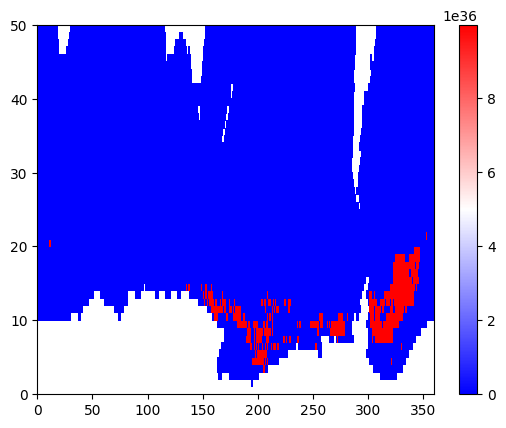

In [7]:
plt.pcolor(DIFF[200],cmap=plt.get_cmap('bwr'))
plt.colorbar()

In [42]:
def myfitting2d_sttcs(data3d,threshold=0.05):
    '''
    Inputs --> data3d (time, lat,lon)
    '''
    # calculate interval manually using the formula
    T,A,O=data3d.shape
    y=np.arange(T)
    slope=np.zeros([A,O])
    intercept,r_value,p_value,std_err,Smask=\
        np.zeros_like(slope),np.zeros_like(slope),np.zeros_like(slope),\
            np.zeros_like(slope),np.zeros_like(slope)
    for i in range(A):
        for j in range(O):
            if np.mean(data3d[:,i,j])!=np.mean(data3d[:,i,j]):
                slope[i,j],intercept[i,j],r_value[i,j],p_value[i,j],std_err[i,j],Smask[i,j]=\
                    np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
            else:
                slope[i,j], intercept[i,j], r_value[i,j], p_value[i,j], std_err[i,j]=\
                    linregress(y,data3d[:,i,j])
                if p_value[i,j]<=threshold or p_value[i,j]>=1-threshold:
                    Smask[i,j]=0
                    print(p_value[i,j])
                else:
                    Smask[i,j]=np.nan

    return slope, intercept, r_value, p_value, std_err, Smask

In [43]:
from netCDF4 import MFDataset,Dataset,num2date,date2num
import statsmodels.api as sm
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import os
import sys
import numpy as np
from scipy.stats import  linregress
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import os

def myCrtpy_sph2(LAT,LON,DATA,CMAP,LEVELS,myName):
    Spheric=ccrs.SouthPolarStereo(central_longitude=0.0,globe=None)
    PC = ccrs.PlateCarree(central_longitude=0.0,globe=None)
    fig, ax = plt.subplots(1, 1, figsize=(12.5,11),
                    subplot_kw={'projection': Spheric})
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cf.COASTLINE.with_scale("110m"), lw=1,zorder=110)
    ax.add_feature(cartopy.feature.LAND,color=[.75,.75,.75],zorder=100)
    ax.set_title(myName,loc='right',fontdict={'fontsize':32,'fontweight':'regular'})

    gl = ax.gridlines(crs=PC, draw_labels=True,y_inline=False,x_inline=False,
                    linewidth=.6, color='k', alpha=0.45, linestyle='-.')
    gl.rotate_labels=False
    gl.xlabels_top,gl.ylabels_right = True,True
    gl.xlabel_style = gl.ylabel_style = {"size" : 26}
    
    M=plt.contourf(LON,LAT,DATA,cmap=CMAP,levels=LEVELS,transform=PC,zorder=0)
    
    ax.set_extent([LON[0][0], LON[0][-1], LAT[0][0], LAT[-1][0]], crs=PC)
    
    ax.tick_params(axis='both', which='major', labelsize=28)

    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=1., axes_class=plt.Axes)
    fig.add_axes(ax_cb)
    cb=plt.colorbar(M,extend='both',pad=0.08,cax=ax_cb)
    cb.set_label(label='', weight='regular',fontsize=28)
    cb.ax.tick_params(labelsize=19)
    plt.tight_layout()
    if 0:
        myName.replace(' ','_')
        # plt.savefig(w_path+'/ppt/'+save_name,
        #         facecolor='none',edgecolor='none',bbox_inches='tight',transparent=True)
    plt.show()
    
def recall_myCMAP(Cname):
    if Cname=='myblc2':
        Mycolorlist=['#1b2c62','#1f4181','#2455a1','#3877ba',\
            '#529bd2','#71b8e4','#91d2f2','#b2e0fa','#cbebf8',\
                '#e3f4fb','#f2f9e3','#fcf0b4','#fddb81','#fdc152',\
                    '#fca12f','#f8822b','#ef5e29','#e03b28','#cc1e27',\
                        '#ae191f']     
    else: 
        pass
    Mycmap = LinearSegmentedColormap.from_list('',Mycolorlist,N=256)
    return Mycmap

def myClrbr(myCname,myLIM,N):
    myCMAP=recall_myCMAP(myCname)
    mylevels=np.linspace(myLIM[0], myLIM[-1], N+1,endpoint=True)
    CMAP = ListedColormap(myCMAP(
    np.linspace(0, 1, len(mylevels)-1,endpoint=True)) )
    return CMAP,mylevels

slope,intercept,r_value,p_value,std_err,smask=myfitting2d_sttcs(HadlSST)



0.00012735285220697088
0.0469779630325951
0.039712843095127306
0.015943673129045596
0.016977533537376768
0.005820417167803128
0.016907913064176116
0.00341658827136799
0.0004031692007539614
0.006333501244463527
0.03189453781321005
0.03280328712321465
0.027723083487105858
0.00033855690891035735
0.001709252195502419
0.0013176418337109527
0.010753223566486845
0.0003990269511648251
0.0003993063432251347
0.0002514997851343759
0.00026702661906761457
0.005688348204041743
0.014488114427824836
0.015768764153920027
0.013037459073342151
0.035654102869651025
0.012929915973958478
0.002628900674999456
0.004401422366375541
0.016592958634321697
0.009590633559941835
0.006317172554225133
0.007331513278972679
0.0007981219661171147
0.001839610769703839
0.006534516178221183
0.9666785050765294
0.01718335176417559
6.189061277413786e-05
0.028705680515872963
0.013936047888064402
0.013933776769032109
0.0001929229626418327
0.012948873539563423
0.0005998813316936885
0.0006163799131801549
0.00012534872646524598
1.9

c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


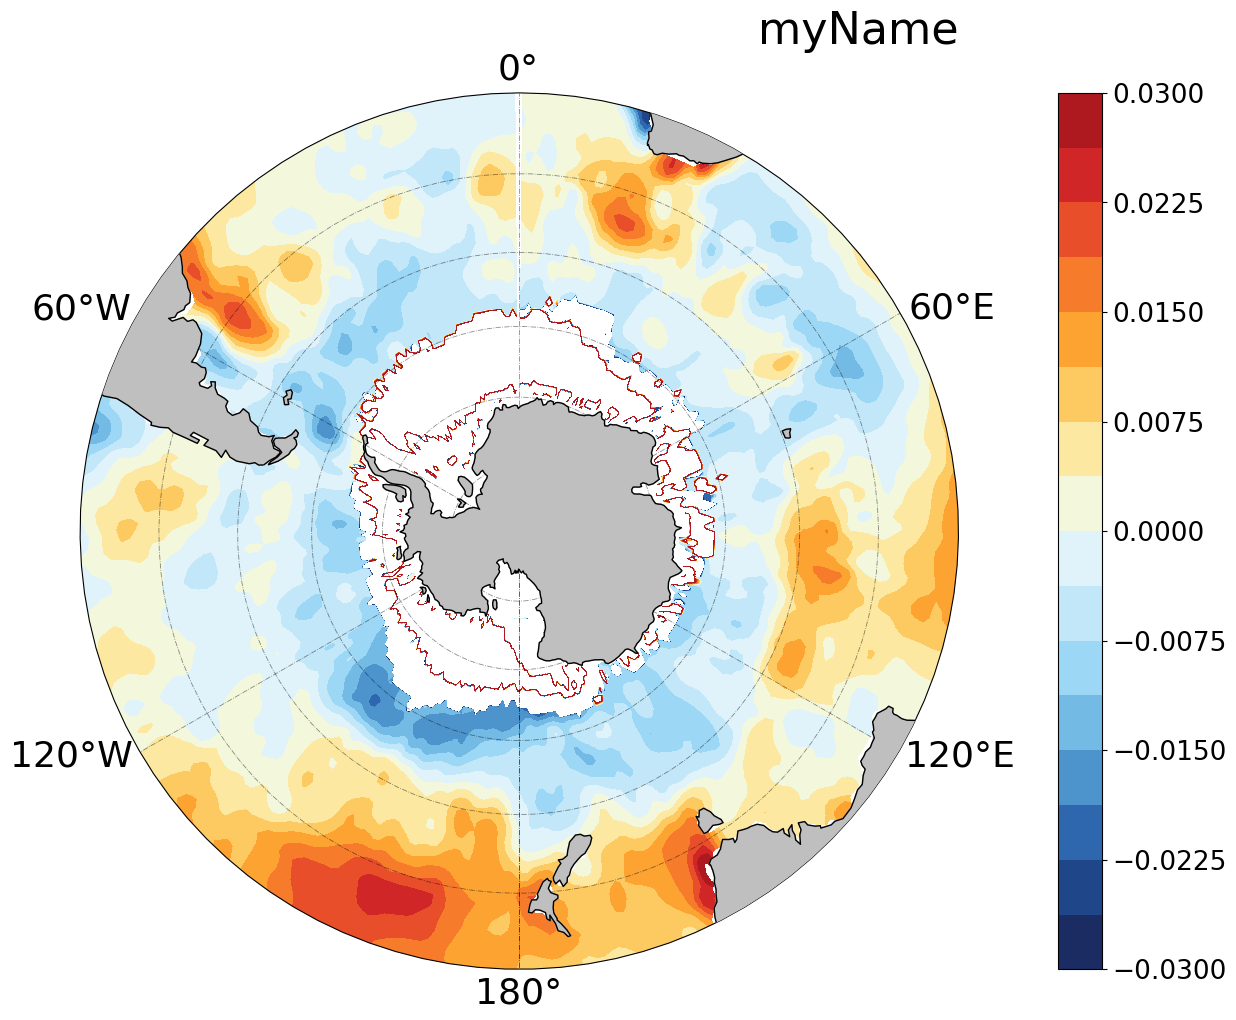

In [31]:
sstTlim=[-0.03,0.03]
slope[slope<sstTlim[0]]=sstTlim[0]
slope[slope>sstTlim[-1]]=sstTlim[-1]
CMAP,mylevel=myClrbr('myblc2',sstTlim,16)

LON_m,lat_m=np.meshgrid(LON,np.flipud(LAT))

myCrtpy_sph2(lat_m,LON_m,slope*12,CMAP,mylevel,'myName')

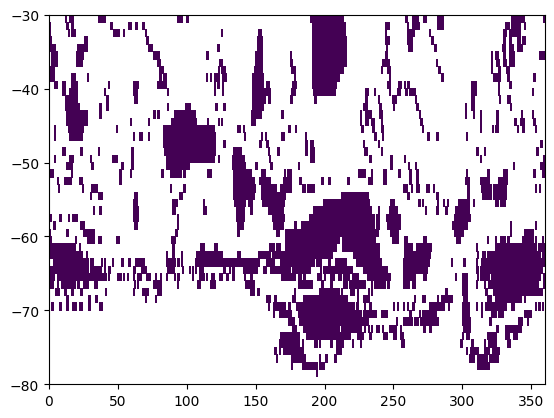

In [35]:
plt.pcolor(LON_m,lat_m,smask)

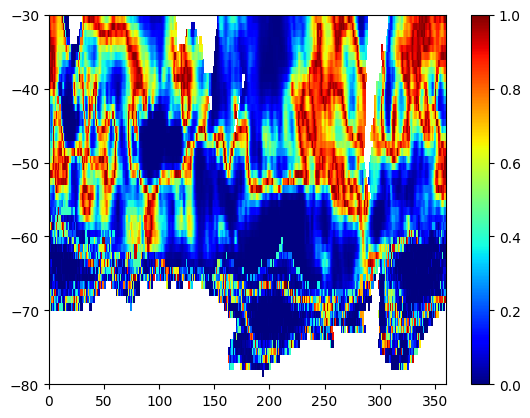

In [41]:
plt.pcolor(LON_m,lat_m,p_value,vmin=0,vmax=1,cmap='jet')
plt.colorbar()